# Credit Risk 2018 by MiBanco

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

sns.set(style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', None)

# Sección 1: Carga y vista general del dataset

In [351]:
df = pd.read_csv('credit_risk_en.csv')

In [352]:
df.head()

,district,commercial_activity,housing_type,sex,age,civil_condition,number_of_children,disbursed_amount,loan_term,guarantor,type_of_warranty,max_days_delay,qualification_system,num_banks,risk_segmentation
0,AHUAC,DEPENDENT,OWN,FEMALE,38,COHABITANT,2,2012.87,12,NO,PROPERTY,0,NORMAL,2,2
1,HUAMANCACA CHICO,DEPENDENT,OWN,MALE,39,COHABITANT,1,45865.30,48,NO,PROPERTY,0,NORMAL,2,3
2,CHUPACA,FAMILY TRADE,FEMALE,FEMALE,42,SINGLE,1,1007.44,12,NO,FURNITURE,0,NORMAL,1,2
3,CHUPACA,DEPENDENT,FAMILIAR,FEMALE,22,SINGLE,0,2012.87,12,YES,PROPERTY,1,NORMAL,1,3
4,CHUPACA,TRADE,OWN,FEMALE,35,COHABITANT,2,1509.71,12,NO,PROPERTY,3,NORMAL,1,3


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district              207 non-null    object 
 1   commercial_activity   207 non-null    object 
 2   housing_type          207 non-null    object 
 3   sex                   207 non-null    object 
 4   age                   207 non-null    int64  
 5   civil_condition       207 non-null    object 
 6   number_of_children    207 non-null    int64  
 7   disbursed_amount      207 non-null    float64
 8   loan_term             207 non-null    int64  
 9   guarantor             207 non-null    object 
 10  type_of_warranty      207 non-null    object 
 11  max_days_delay        207 non-null    int64  
 12  qualification_system  207 non-null    object 
 13  num_banks             207 non-null    int64  
 14  risk_segmentation     207 non-null    int64  
dtypes: float64(1), int64(6)

In [354]:
print(f'Conteo de valores nulos por columna:\n{df.isnull().sum()}')

Conteo de valores nulos por columna:
district                0
commercial_activity     0
housing_type            0
sex                     0
age                     0
civil_condition         0
number_of_children      0
disbursed_amount        0
loan_term               0
guarantor               0
type_of_warranty        0
max_days_delay          0
qualification_system    0
num_banks               0
risk_segmentation       0
dtype: int64


In [355]:
print(f'Cantidad de filas duplicadas: {df.duplicated().sum()}')

Cantidad de filas duplicadas: 0


## Observaciones
- Existen 14 columnas, donde `risk_segmentation` es el target
- No existen valores nulos en las columnas
- No existen filas duplicadas

# Sección 2: Exploración Univariada

## Exploración de variables numéricas

In [356]:
num_cols = ['age', 'number_of_children', 'disbursed_amount', 'loan_term',
           'max_days_delay', 'num_banks']

In [357]:
def plotNumeric(num_cols):
    for i, col in enumerate(num_cols, 1):
        plt.subplot(3, 2, i)
        sns.histplot(df[col], kde=True, bins=15, color='steelblue')
        plt.title(f'Distribución de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

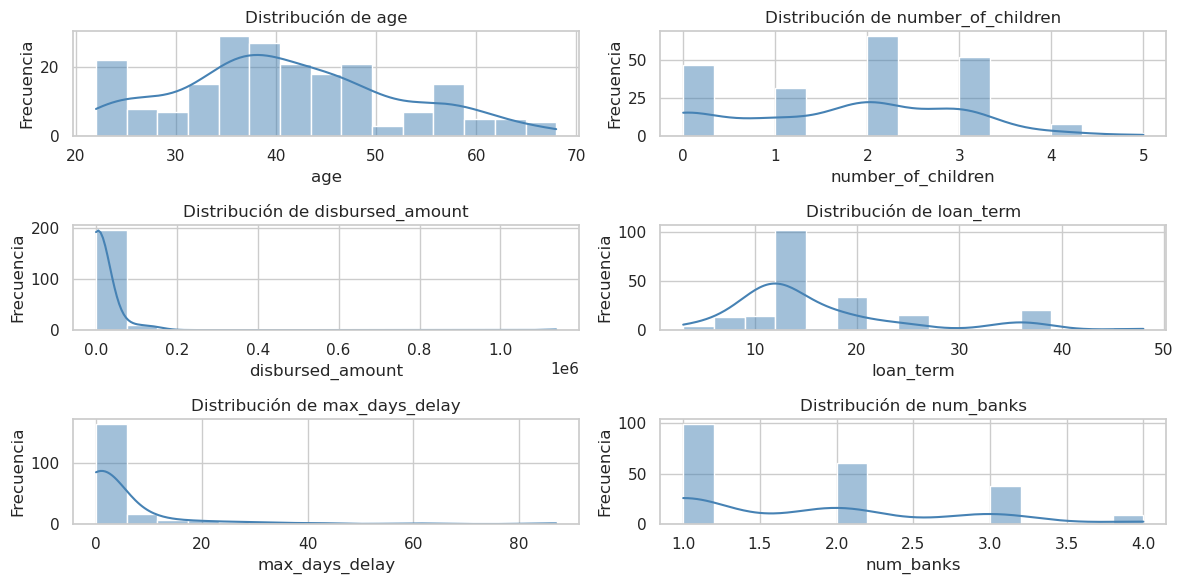

In [358]:
plotNumeric(num_cols)

### Observaciones
- La distribución de `age` se muestra dispersa, con una pequeña concentración entre los 35 y 50 años.
- La distribución de `number_of_children` se muestra dispersa en un rango de 0 a 5, aunque se observa muy poca concentración de datos en los valores 4 y 5.
- La distribución de `disbursed_amount` se muestra claramente sesgada al a derecha, presenta outliers muy extremos a la derecha. Además, los registros se muestran concentrados en los valores iguales o cercanos al 0.
- La distribución de `loan_term` se muestra dispersa en aunque con un leve sesgo a la derecha.
- La distribución de `max_days_days` se muestra fuertemente sesgada a la derecha, presentando también outliers a la derecha. Además, los registros se muestran concentrados en los valores iguales o cercanos al 0.
- La distribución de `num_banks` se muestra dispersa pero algo sesgada a la derecha, y algo concentrada en los valores 1 y 2.
- Ninguna de las distribuciones sigue la normal.

## Exploración de variables Categóricas

In [359]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols += ['risk_segmentation']

In [360]:
def plotCategoric(cat_cols):
    for col in cat_cols:
        ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        ax.bar_label(ax.containers[0])
        plt.title(f'Distribución de {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

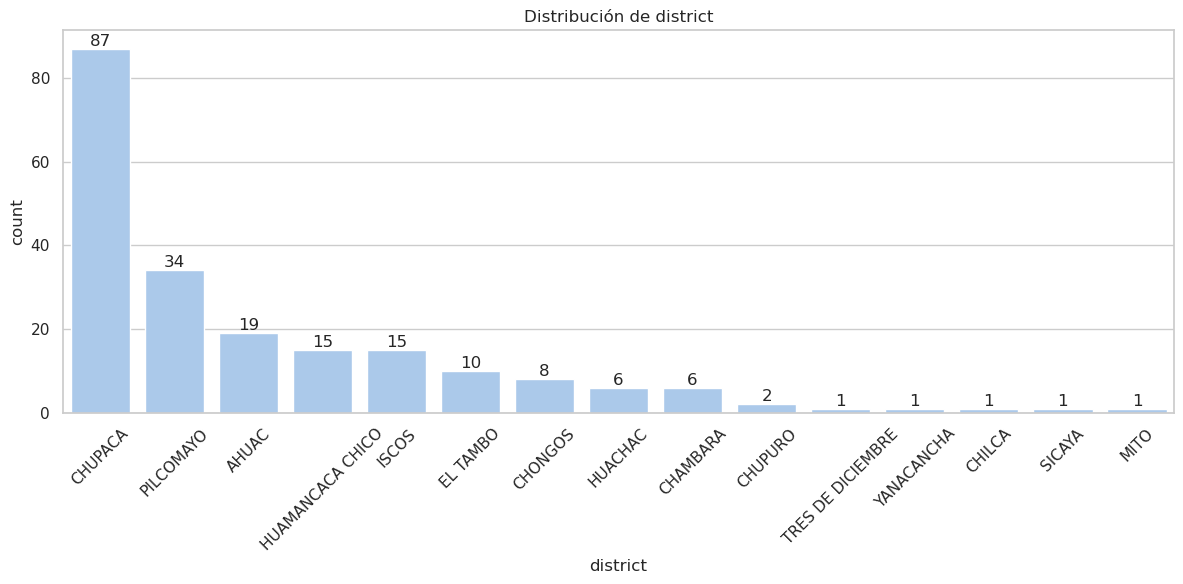

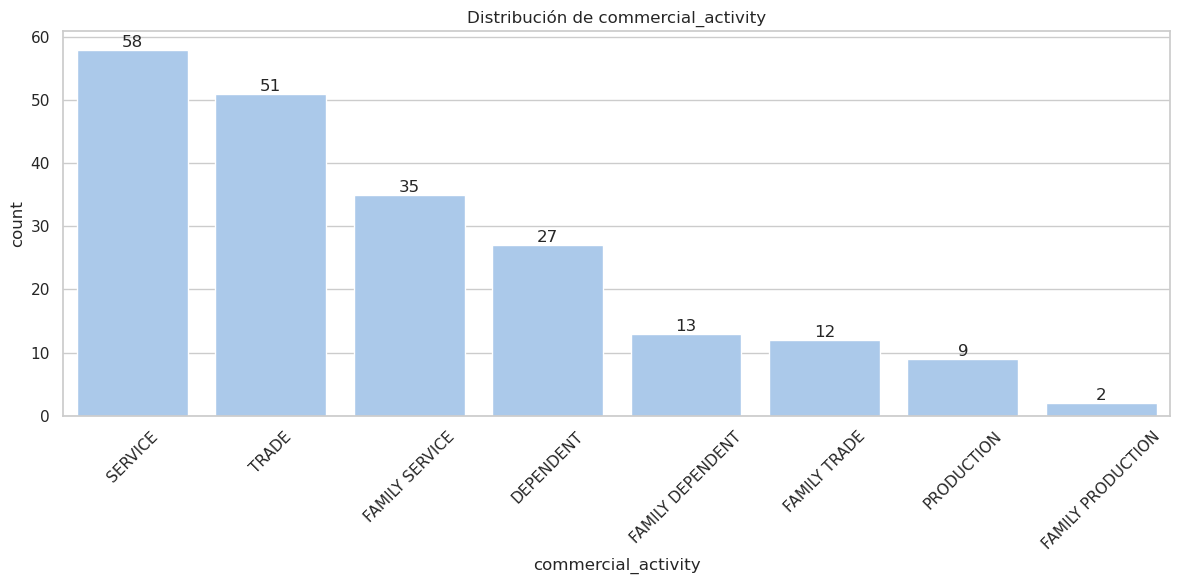

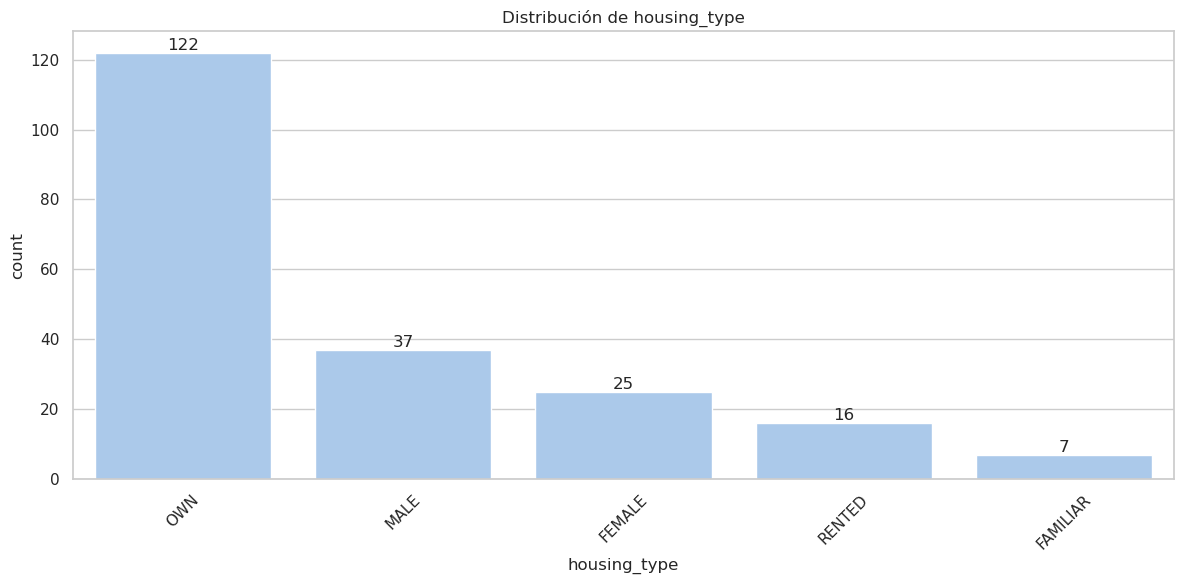

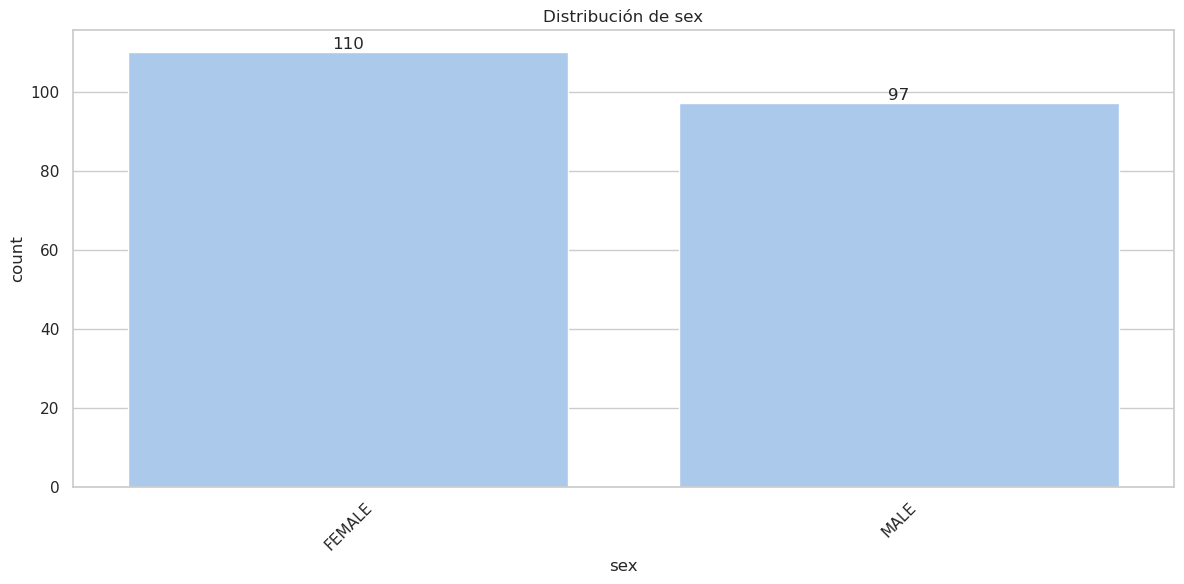

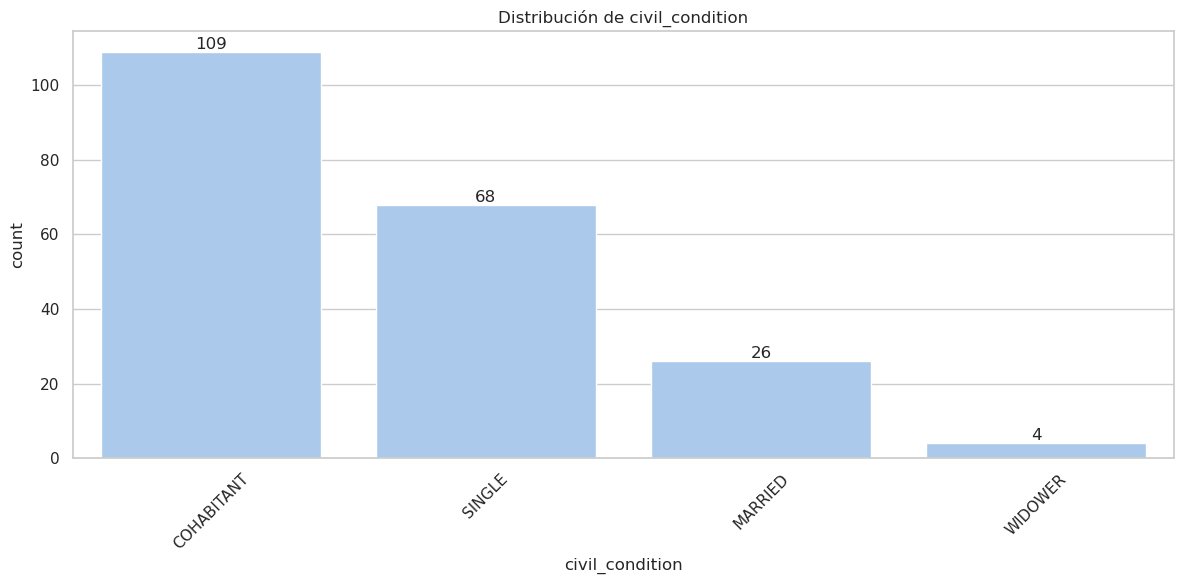

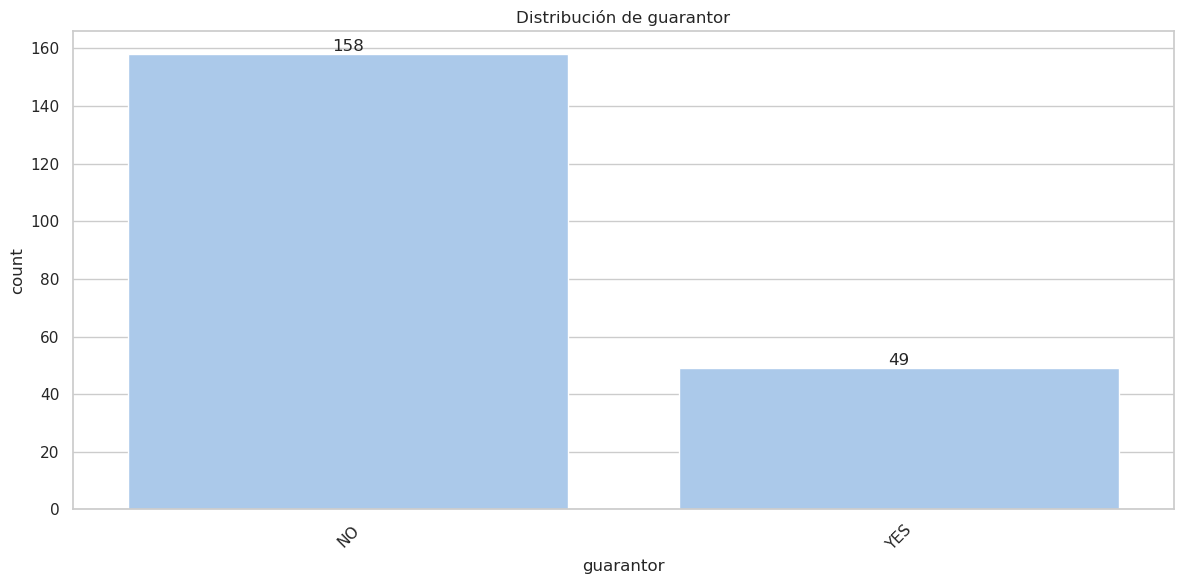

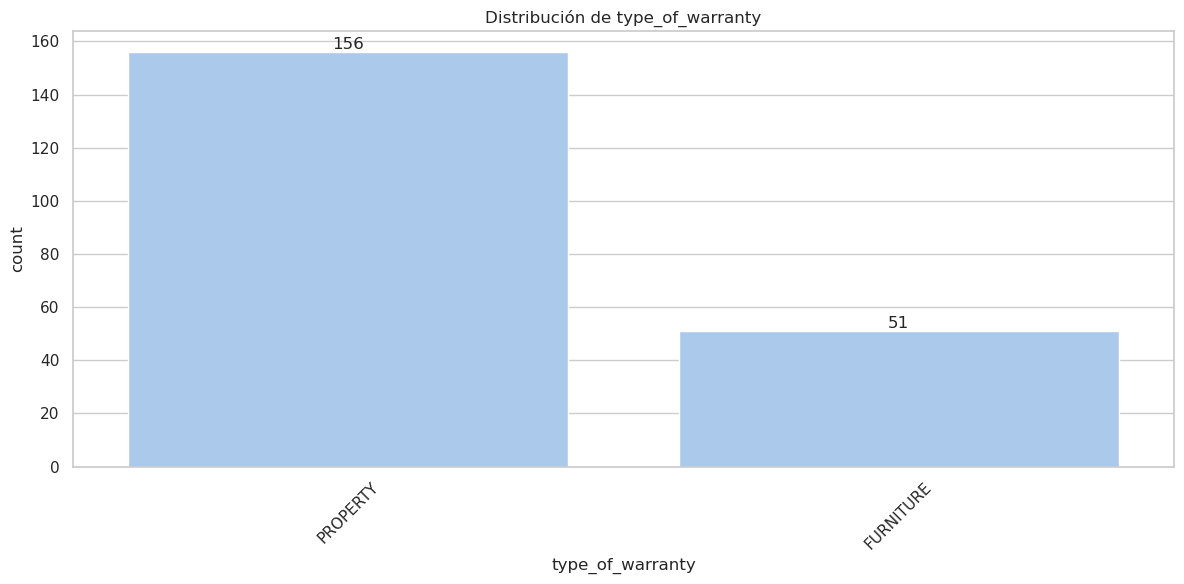

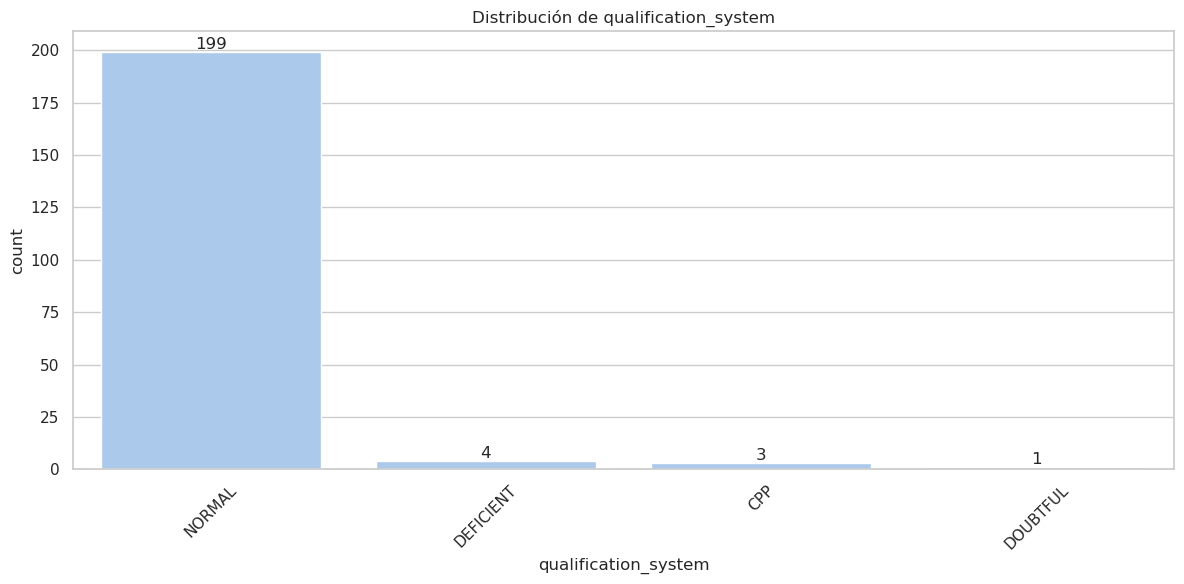

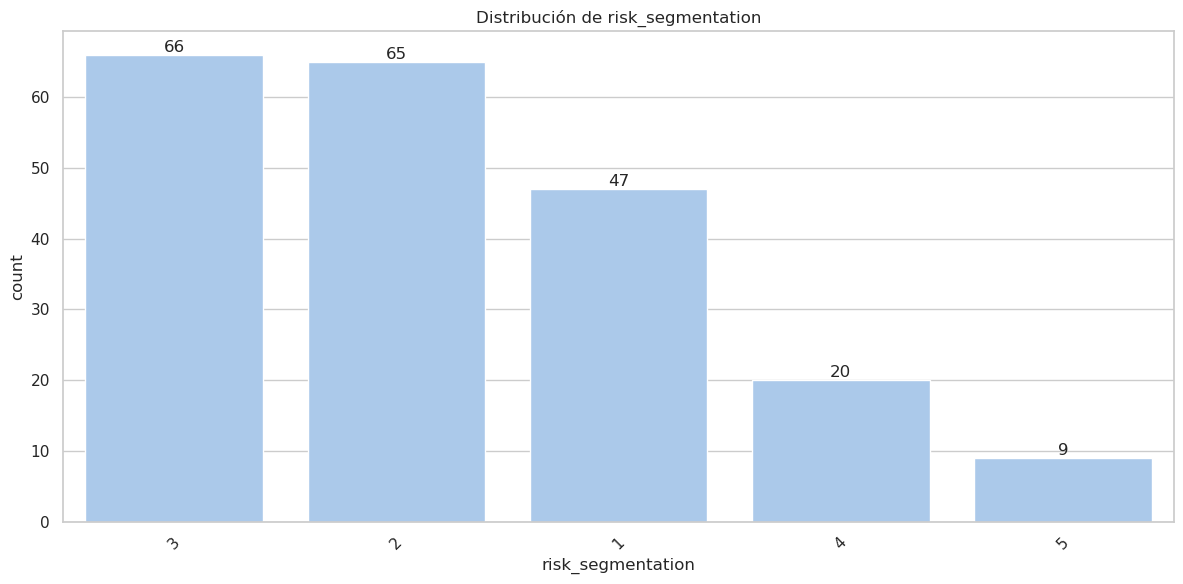

In [361]:
plotCategoric(cat_cols)

### Observaciones
- Los **distritos** más represantativos en el datset son `Chupalca` con 87 registros y `Pacalmayo` con 34 registros. Mientras los demás no superan los 20 registros y existen 6 distritos con menos de 6 registros (4 de ellos con solo 1 observación). Los distritos con menos de 6 entradas serán agrupados en **OTROS**.
- Las **actividades comerciales** más representativas son `Service` con 58 registros y `Trade` con 51 registros. Después, varian mucho los conteos entre 35 y 2, resaltando la actividad `Family production` que tiene solo 2, por lo que se debería agrupar en **OTROS** para evitar overfitting.
- La mayoría de **tipos de casa** es `own` con 122 registros. Sin embargo, existe inconsistencia en los registros, debido a que se presentan valores como **MALE** (37 registros) y **FEMALE** (25 registros) en tipos de casa.
- Con respecto al **sexo**, existen 110 observaciones de `Female` y 97 de `Male`, demostrando que la muestra está balanceada.
- Con respecto a la **condición civil**, la mayoría de personas son **Cohabitant** (109 observaciones) y **WIDOWER** es una categoría con muy poca represntación (4 registros)
- En la muestra se verifica que se dan más préstamos **sin garantía** (158 registros) que **con garantía** (49 registros), lo que podría ser un indicador de confianza crediticia.
- Los **tipos de categoría** son **PROPERTY** y **FURNITURE**, siendo el primero el de mayor representatividad con 156 observaciones. Por lo tanto, se deberá trasnformar a una nueva variable **IS_PROPERTY** para simplificar la representación.
- La mayoría de **sistemas de califación** están en **NORMAL** y todas las demás no superan los 4 registros, siendo **DOUBTFUL** el menos representativo con 1 observación. Por lo tanto, se puede transformar la variable para que represente **IS_NORMAL**.
- El **riesgo** está distribuido en 5 categorías: 1 (muy bajo riesgo), 2 (bajo riesgo), 3 (medio riesgo), 4 (alto riesgo) y 5 (muy alto riesgo). La gráfica nos demuestra que existen más observaciones en riesgos muy bajo, bajo y medio; y muy pocas observaciones en riesgo alto y muy alto. El riesgo con menor represntación en la muestra es el 5 con solo 9 observaciones.

# Sección 3: Exploración Bivariada

## Variables numéricas vs. Risk_segmentation

In [362]:
def plotBivarNum(num_cols):
    for col in num_cols:
        sns.boxplot(x='risk_segmentation', y=col, data=df)
        plt.title(f'Distribución de {col} según nivel de riesgo')
        plt.xlabel('Segmento de riesgo')
        plt.ylabel(col)
        plt.show()

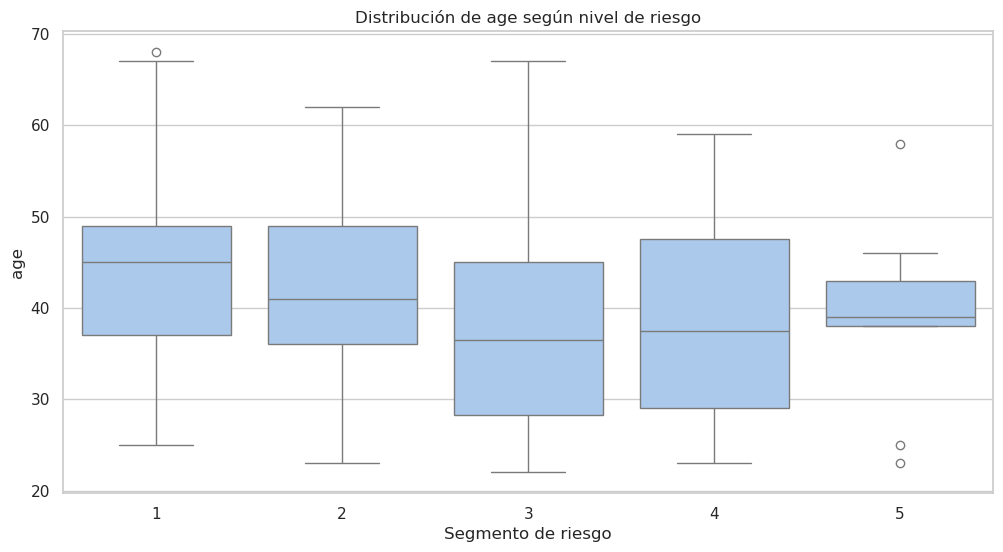

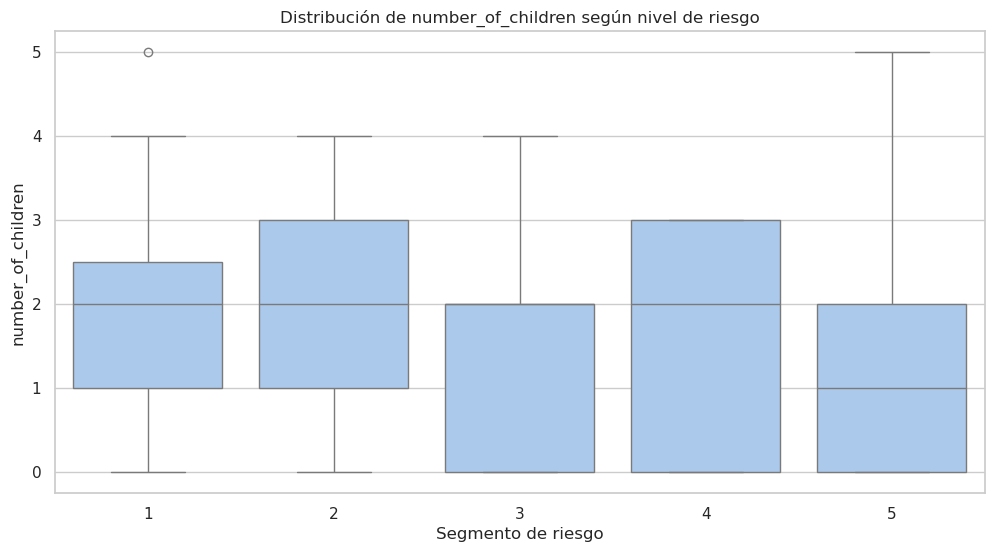

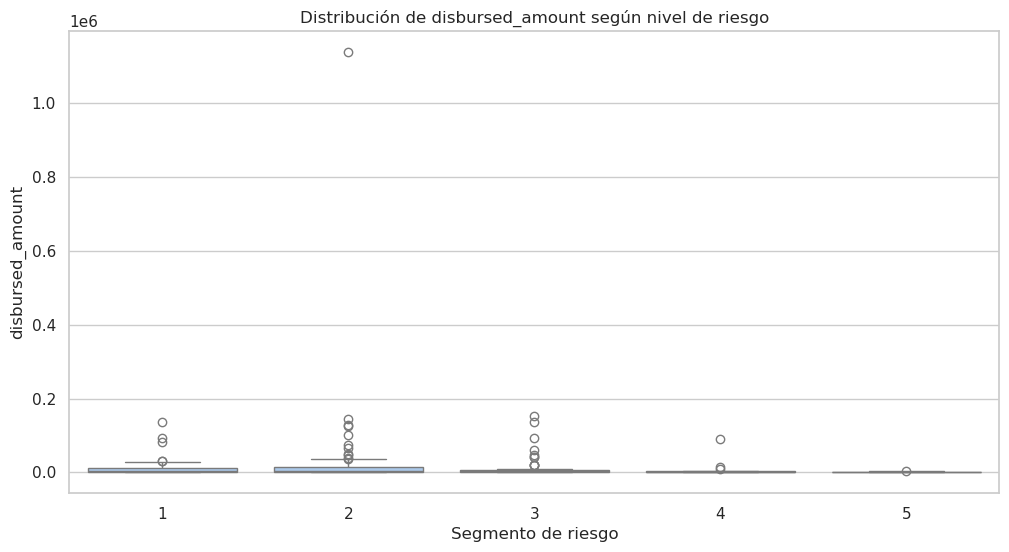

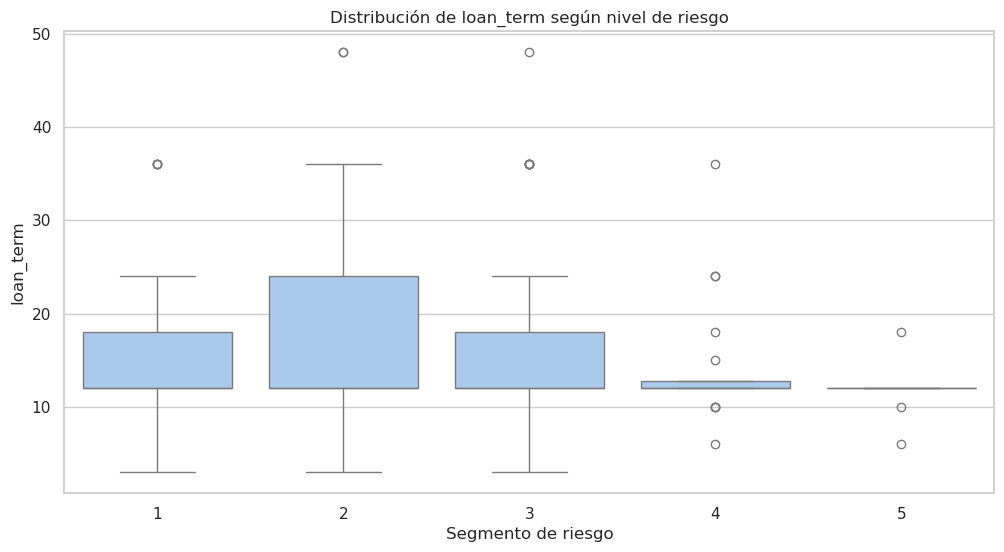

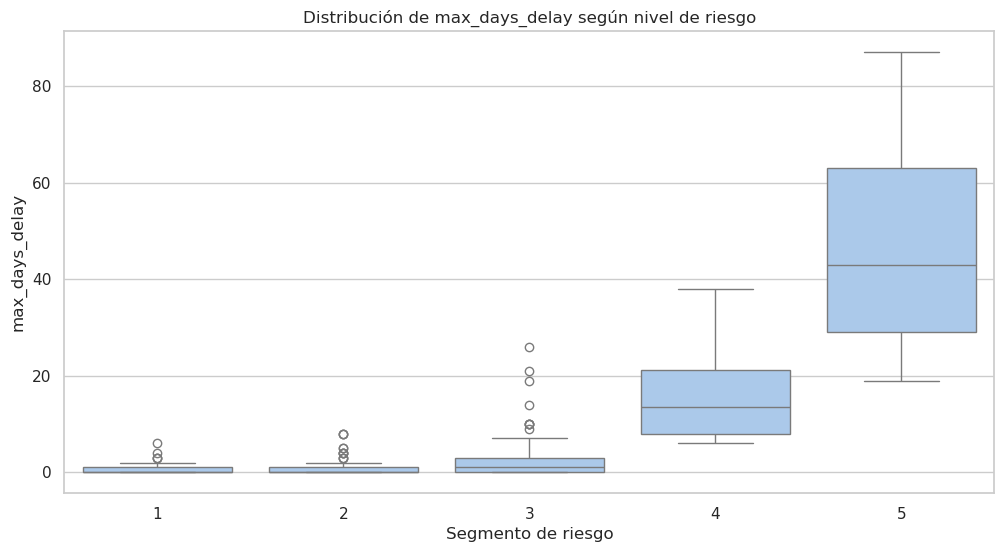

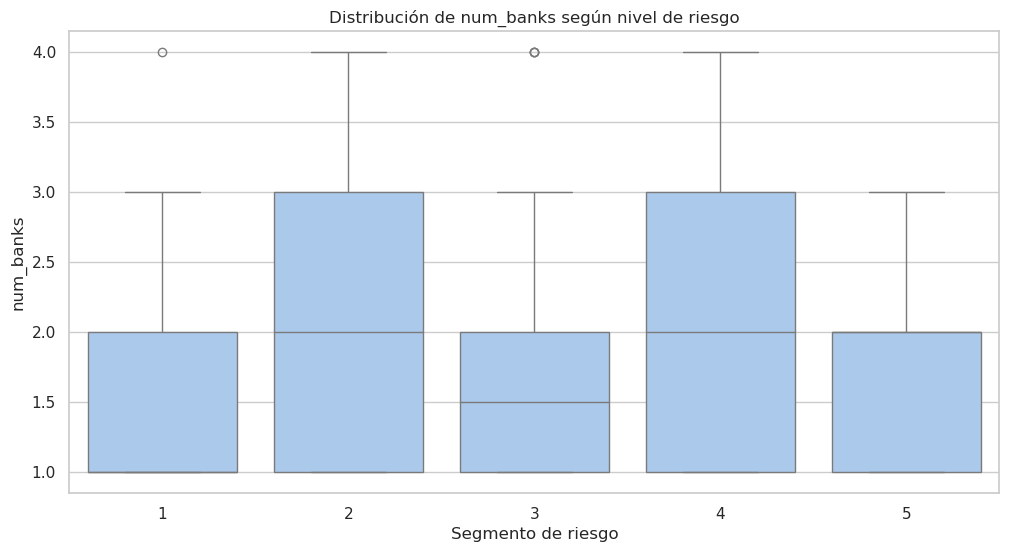

In [363]:
plotBivarNum(num_cols)

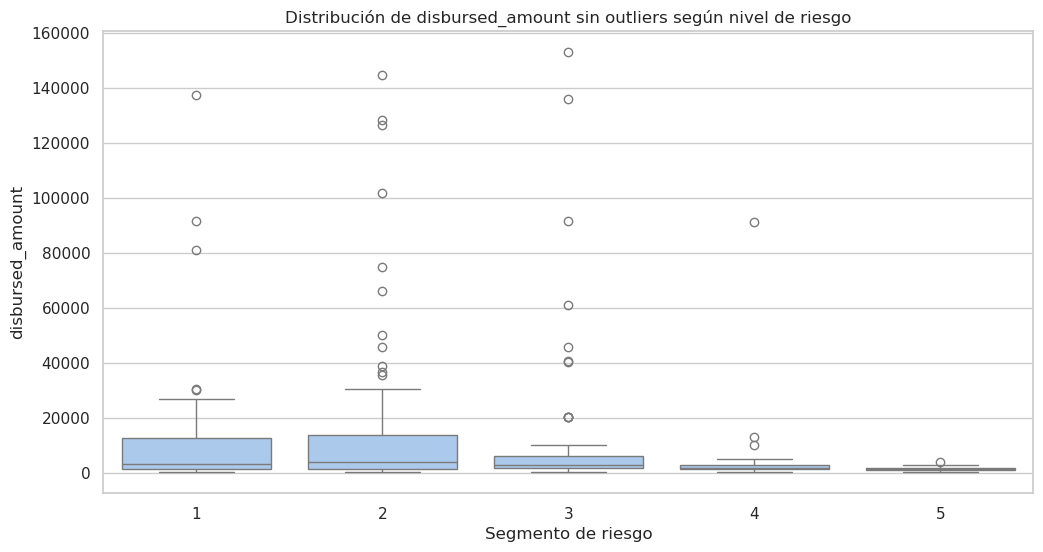

In [364]:
df_trim = df[df['disbursed_amount'] < 1e6]
sns.boxplot(data=df_trim, x='risk_segmentation', y='disbursed_amount');
plt.title('Distribución de disbursed_amount sin outliers según nivel de riesgo');
plt.xlabel('Segmento de riesgo')
plt.ylabel('disbursed_amount')
plt.show()

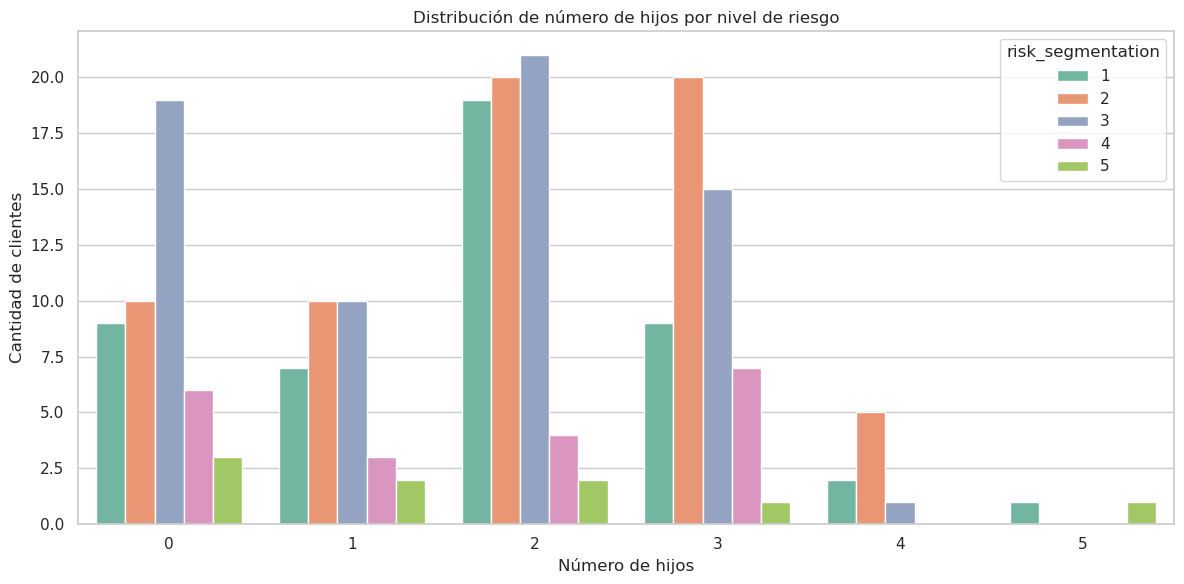

In [365]:
sns.countplot(data=df, x='number_of_children', hue='risk_segmentation',
              palette='Set2');
plt.title('Distribución de número de hijos por nivel de riesgo')
plt.xlabel('Número de hijos')
plt.ylabel('Cantidad de clientes')
plt.tight_layout()

### Observaciones
- Mientras los valores de **MAX_DAYS_DELAY** aumentan, la mediana de los niveles de riesgo también aumenta, demostrando que mientras mayor sea el retraso, mayor será el nivel de riesgo credicio.
- La variable que mayor claridad muestra para separar los niveles de riesgo es **MAX_DAYS_DELAY**.
- Existe un outlier relevante en **DISBURSED_AMOUNT** donde el valor de este ourlier es de 1e6, cuando los valores están entre 20e3 y 16e4.
- Existen variables con mucha superposición como **LOAN TERM**, **DISBURSED_AMOUNT**, porque sus medias son muy similares. Y existen otras que tienen una supersposión regular como **AGE**, **NUMBER OF CHILDREN** y **NUM BANKS**.
- Los segmentos de bajo riesgo (1 y 2) se concentran más en las personas con 2 y 3 hijos. Los segmeos de alto riesgo (4 y 5) tienen mayor proporción en las personas sin hijos y con 3 hijos. Por último, existen categorías con muy poca representación como los clientes con 4 y 5 hijos.

## Variables categóricas vs. Risk Segmentation

In [366]:
target = 'risk_segmentation'

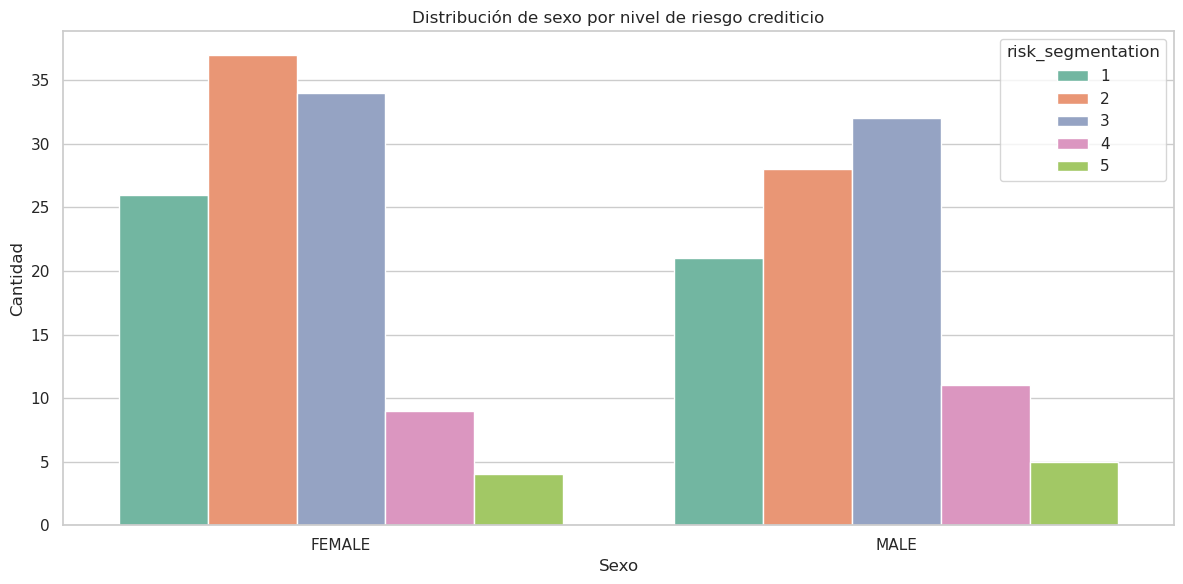

In [367]:
sns.countplot(data=df, x='sex', hue='risk_segmentation', palette='Set2')
plt.title('Distribución de sexo por nivel de riesgo crediticio')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')
plt.tight_layout()

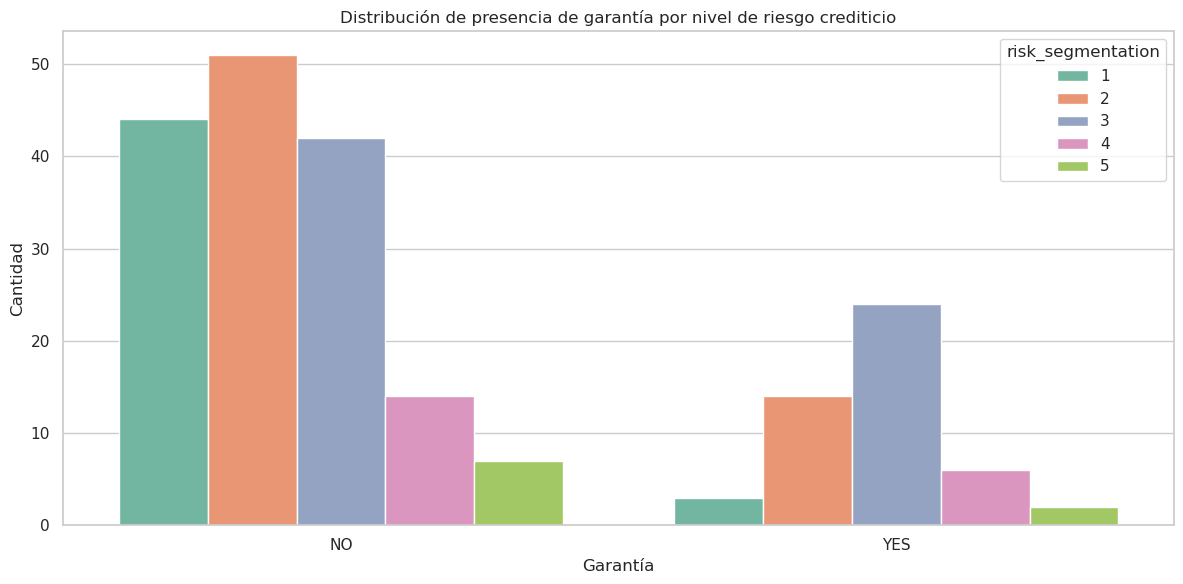

In [368]:
sns.countplot(data=df, x='guarantor', hue='risk_segmentation', palette='Set2')
plt.title('Distribución de presencia de garantía por nivel de riesgo crediticio')
plt.xlabel('Garantía')
plt.ylabel('Cantidad')
plt.tight_layout()

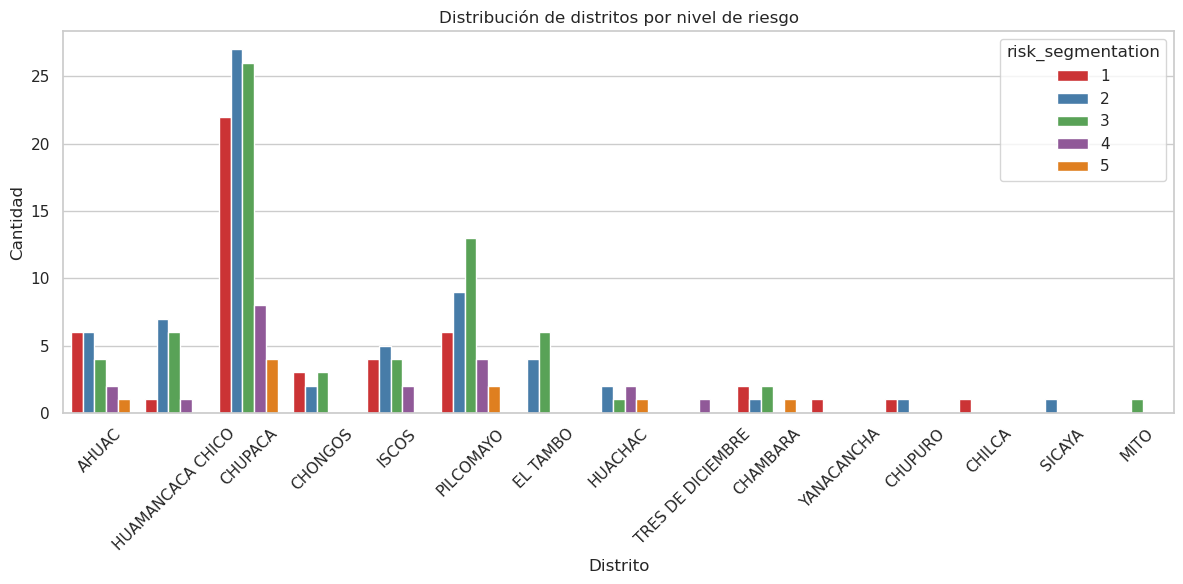

In [369]:
sns.countplot(data=df, x='district', hue=target, palette='Set1')
plt.title('Distribución de distritos por nivel de riesgo')
plt.xticks(rotation=45)
plt.xlabel('Distrito')
plt.ylabel('Cantidad')
plt.tight_layout()

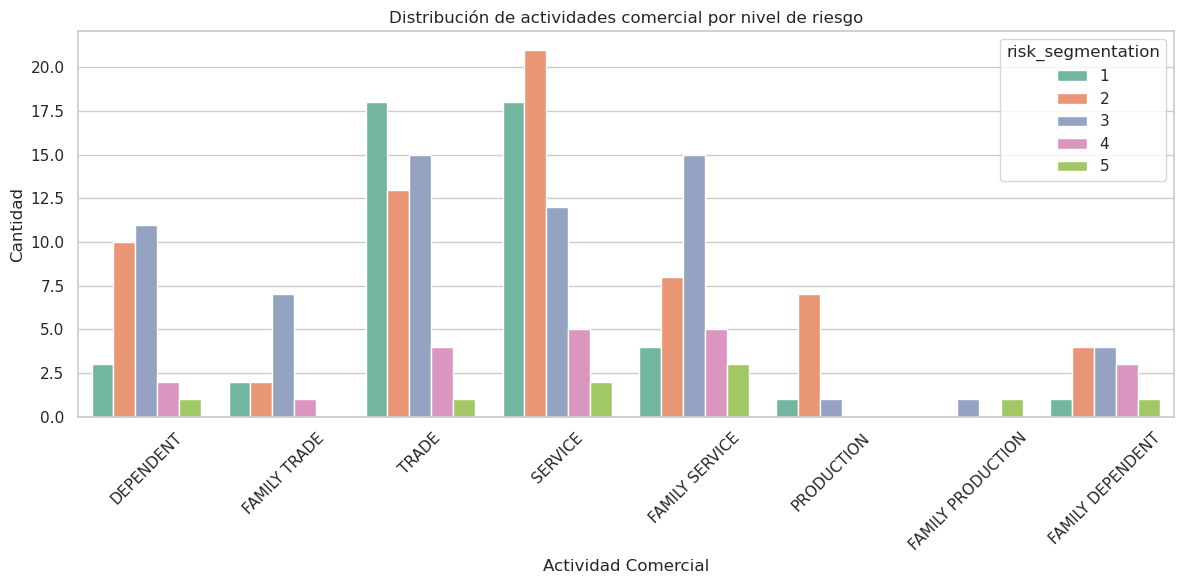

In [370]:
sns.countplot(data=df, x='commercial_activity', hue=target, palette='Set2')
plt.title('Distribución de actividades comercial por nivel de riesgo')
plt.xticks(rotation=45)
plt.xlabel('Actividad Comercial')
plt.ylabel('Cantidad')
plt.tight_layout()

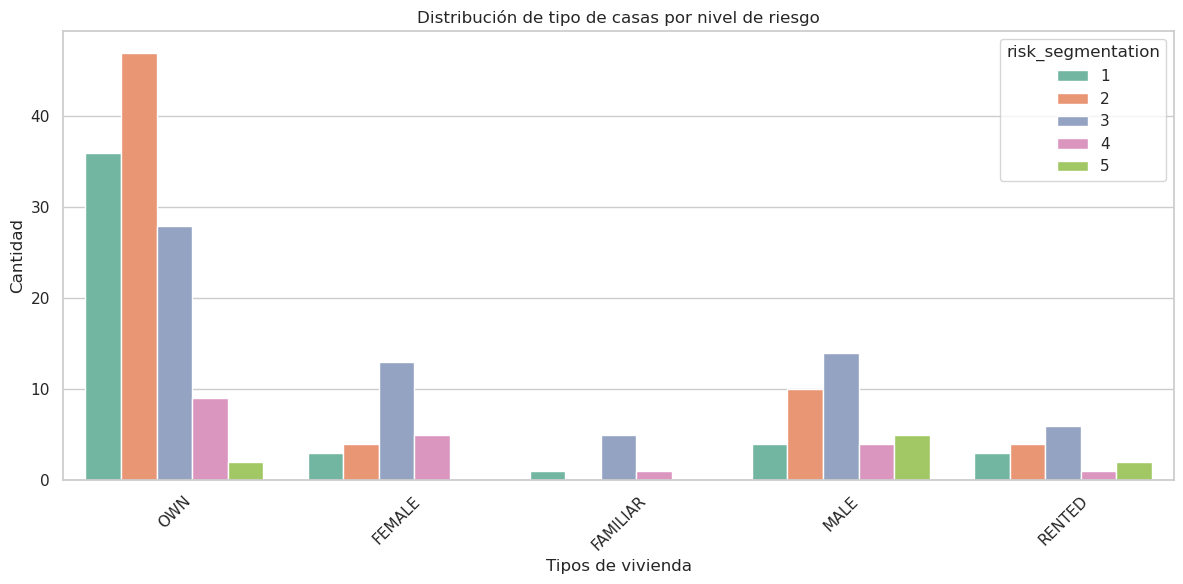

In [371]:
sns.countplot(data=df, x='housing_type', hue=target, palette='Set2')
plt.title('Distribución de tipo de casas por nivel de riesgo')
plt.xticks(rotation=45)
plt.xlabel('Tipos de vivienda')
plt.ylabel('Cantidad')
plt.tight_layout()

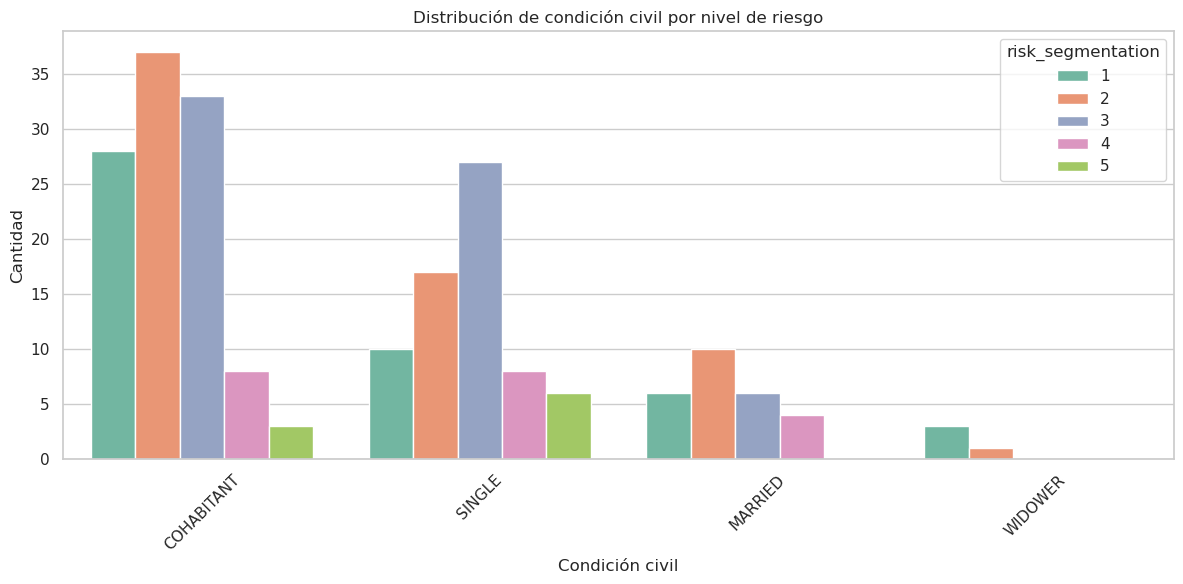

In [372]:
sns.countplot(data=df, x='civil_condition', hue=target, palette='Set2')
plt.title('Distribución de condición civil por nivel de riesgo')
plt.xticks(rotation=45)
plt.xlabel('Condición civil')
plt.ylabel('Cantidad')
plt.tight_layout()

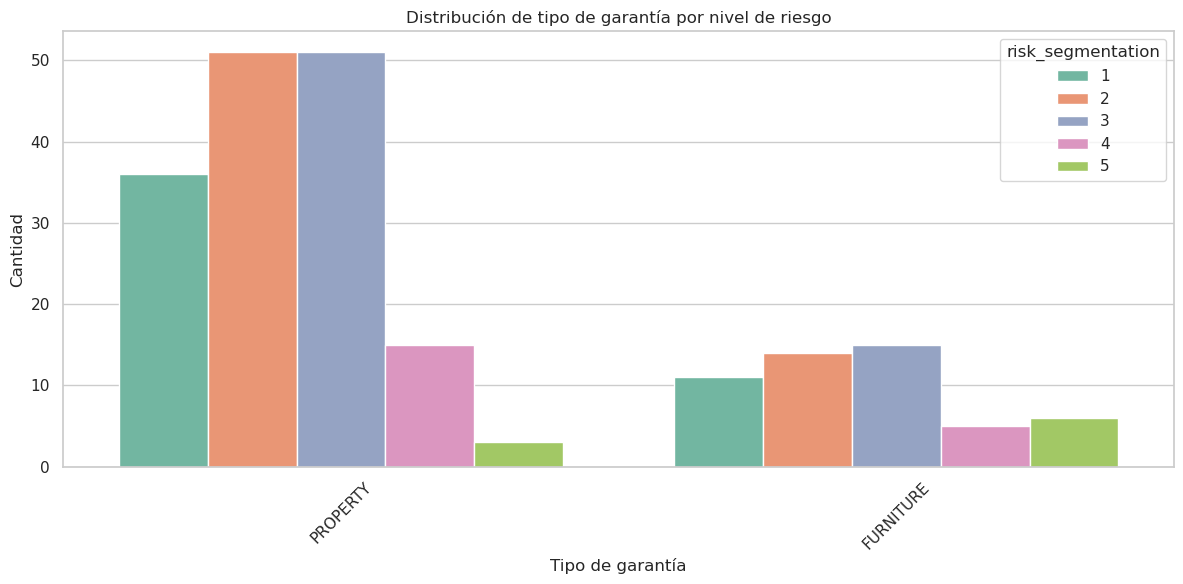

In [373]:
sns.countplot(data=df, x='type_of_warranty', hue=target, palette='Set2')
plt.title('Distribución de tipo de garantía por nivel de riesgo')
plt.xticks(rotation=45)
plt.xlabel('Tipo de garantía')
plt.ylabel('Cantidad')
plt.tight_layout()

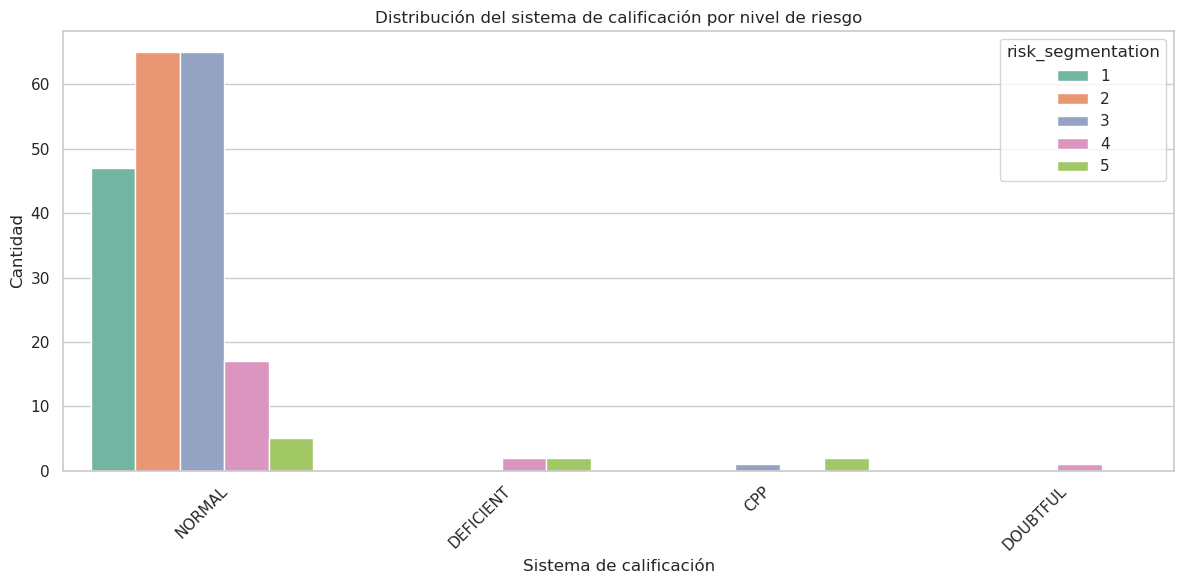

In [374]:
sns.countplot(data=df, x='qualification_system', hue=target, palette='Set2')
plt.title('Distribución del sistema de calificación por nivel de riesgo')
plt.xticks(rotation=45)
plt.xlabel('Sistema de calificación')
plt.ylabel('Cantidad')
plt.tight_layout()

### Observaciones
- Cuando hay **presencia de garantías**, los niveles de riesgo se concentran en el nivel medio (3), mientras cuando no hay garantías, se concentran en los niveles bajos (1 y 2) y medios (3). Esto se puede traducir a mayor confianza crediticia a aquellos clientes a los que no se les solicita garantías.
- En los **distritos** con mayor registros, los niveles de riesgo 2 y 3 tienden a tener más ocurrencias.
- En la mayor concentración de **actividades comerciales** se destacan los riesgos de nivel bajo y medio, aunque también están presente los niveles de riesgo altos aunque no en la misma proporción que los otros. Una observación interesante ocurre en **FAMILY SERVICES** porque aunque no tiene una concentración alta de entradas, tiene una proporción casi simétrica en niveles de riesgo bajo (2), medio (3) y alto (4).
- El nivel bajo se concentra más en los **tipo de casa** **OWN**, mientras que hay una dispersión en los otros tipos de vivienda. Hay que tener en cuenta que en esta variable existe la inconsistencia de los valores **MALE** y **FEMALE**.
- No existen niveles muy altos de riesgo (5) en **condición civil** de tipo **MARRIED** y **WIDOWED**.
- No existen niveles bajos de riesgo (1 y 2) en las personas con **sistema de calificación** que no sea **NORMAL**.

# Sección 4: Análisis Multivariado

## Análisis de variables numéricas

In [375]:
num_cols = df.select_dtypes(include=[int, float]).columns

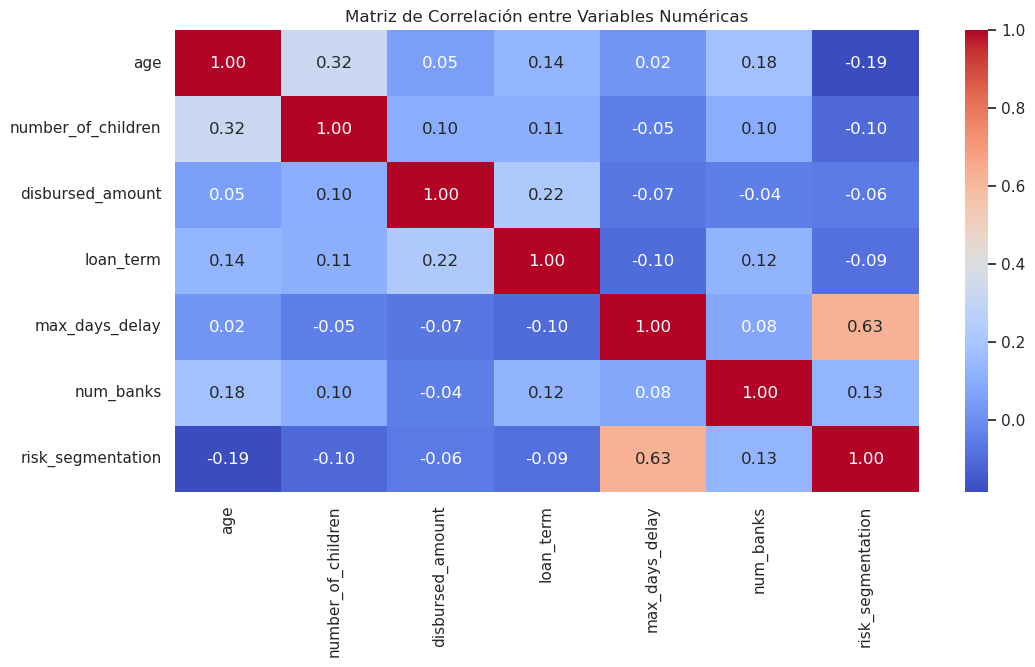

In [376]:
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Variables Numéricas');

### Observaciones de Correlación
- La variable **MAX_DAYS_DELAY** está altamente relacionada con el target con un score de 0.63.
- Existe una correlación de leve (0.32) entre **NUMBER OF CHILDREN** y **AGE**.
- Existe una correlacioń leve (0.22) entre **DISBURSED AMOUNT** y **LOAN TERM**.

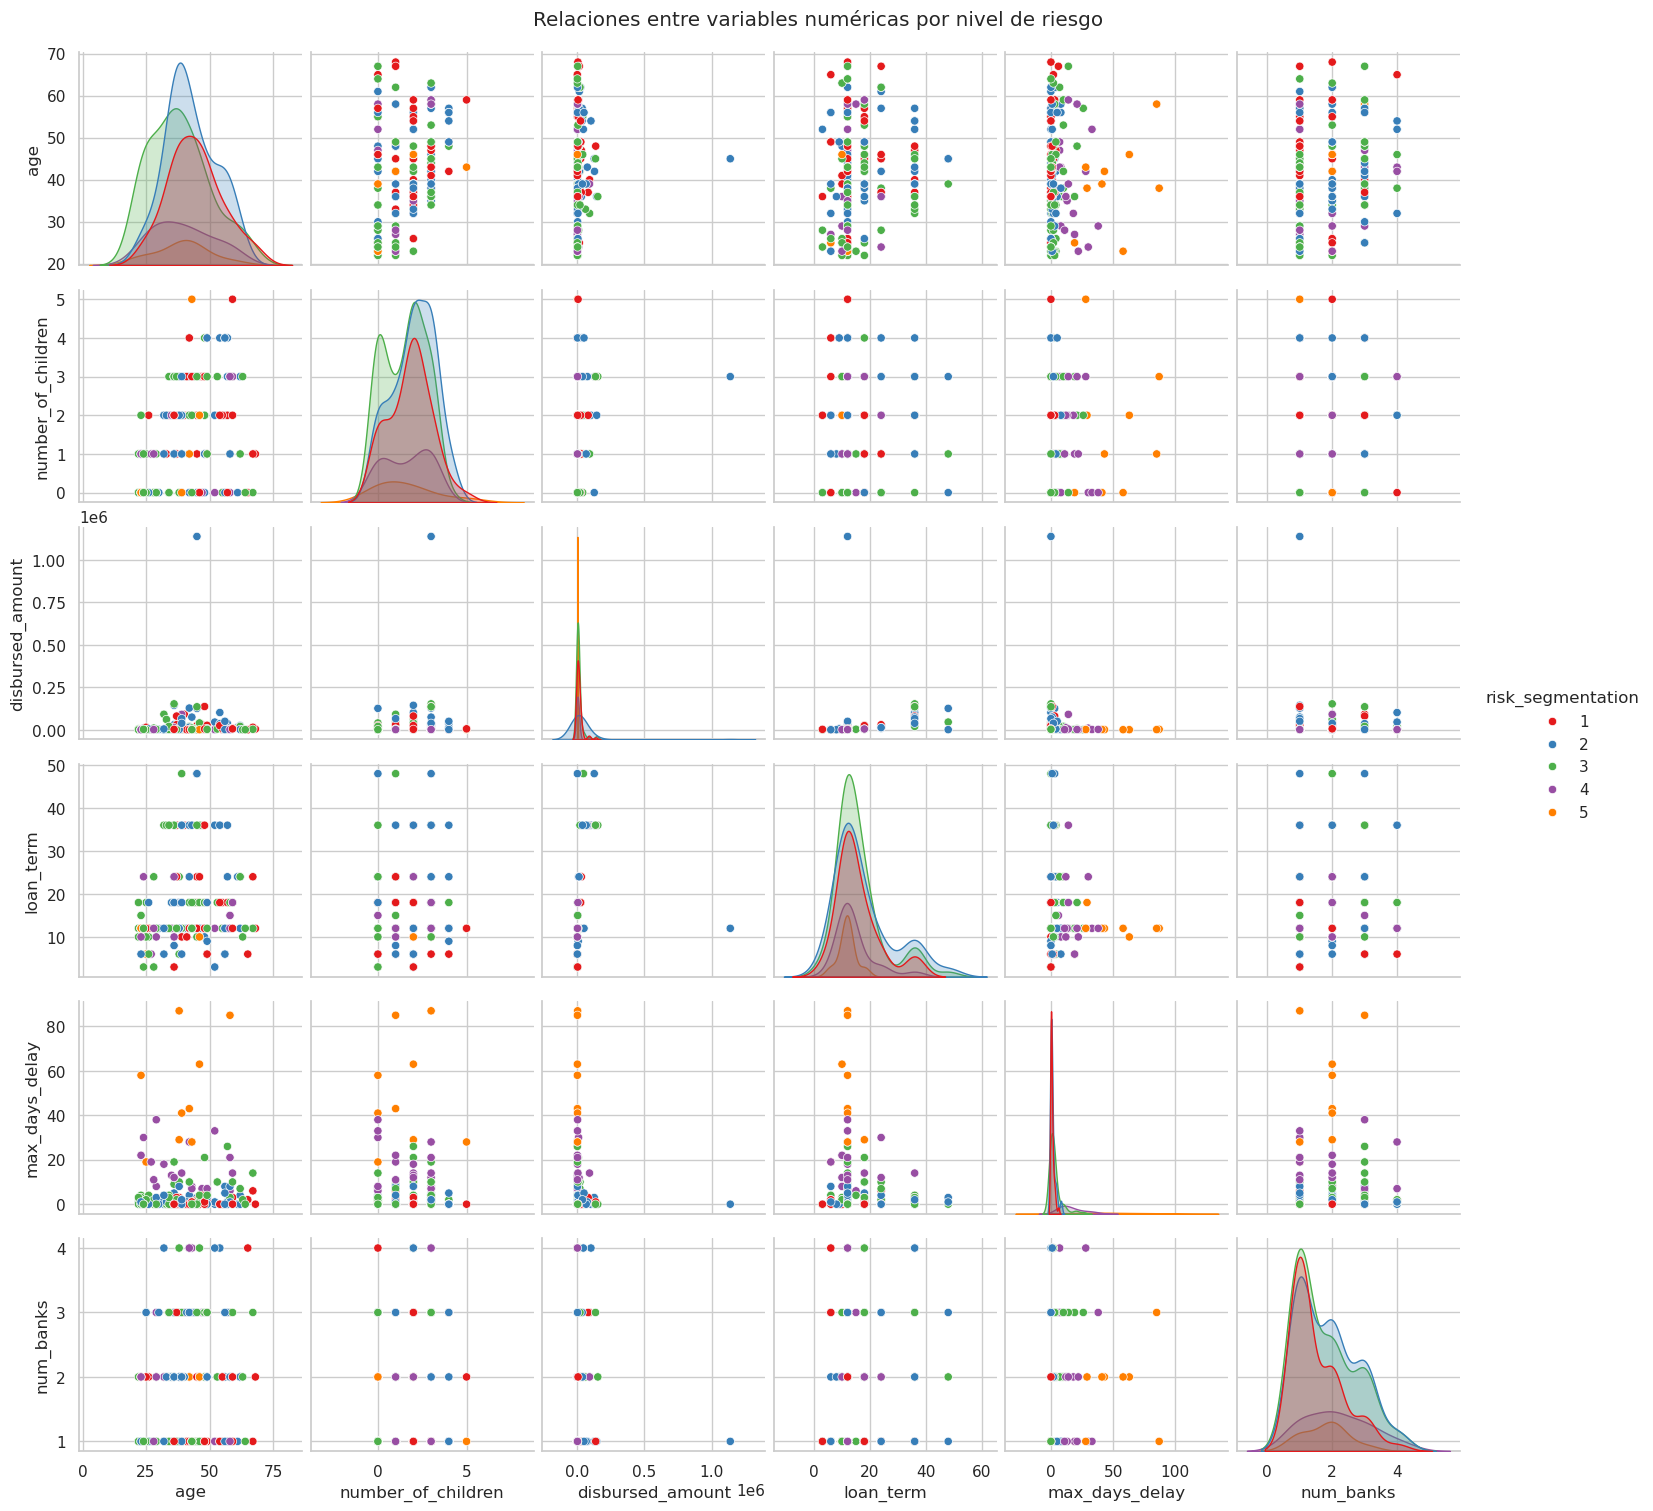

In [377]:
sns.pairplot(df, vars=num_cols.drop('risk_segmentation'), hue='risk_segmentation', palette='Set1')
plt.suptitle('Relaciones entre variables numéricas por nivel de riesgo', y=1.01);

### Observaciones de Scatterplot
- En las combinaciones con **MAX DAYS DELAY** se puede observar que mientras más delay haya, es sencillo identificar el riesgo muy alto. Se puede agregar un feature que indique si el delay es alto o no.
- Como ya observamos en otras exploraciones, **DISBURSED_AMOUNT** tiene un outlier y se tendría que suavizar.
- Se puede observar que los riesgos altos suelen aparecer con **LOAN TERM** cortos. Por lo tanto, se podría crear un feature que destaque los **LOAN TERM** cortos.

# Sección 5: Preprocesamiento de datos

## 1. Corrección de inconsistencias
- Los valorse que no son 'OWN' y 'RENTED' serán puesto es una nueva categoría 'OTHER', debido a que no tienen lógica y no estaban en la descripción de la data.

In [378]:
df['housing_type'] = df['housing_type'].replace(
    {'MALE': 'OTHER', 'FEMALE': 'OTHER', 'FAMILIAR': 'OTHER'}
)

In [379]:
df['housing_type'].unique()

array(['OWN', 'OTHER', 'RENTED'], dtype=object)

In [380]:
df.shape

(207, 15)

## 2. Agrupamiento de valores

In [381]:
# Agrupamos los distritos con menos de 10 registros en 'OTHER'
district_counts = df['district'].value_counts()
low_freq_districts = district_counts[district_counts < 10].index
df['district'] = df['district'].apply(lambda x: 'OTHER' if x in low_freq_districts else x)

# Agrupamos las actividades comerciales con menos de 20 registros en 'OTHER'
activity_counts = df['commercial_activity'].value_counts()
low_freq_activities = activity_counts[activity_counts < 20].index
df['commercial_activity'] = (df['commercial_activity']
    .apply(lambda x: 'OTHER' if x in low_freq_activities else x)
                            )

In [382]:
df['district'].unique()

array(['AHUAC', 'HUAMANCACA CHICO', 'CHUPACA', 'OTHER', 'ISCOS',
       'PILCOMAYO', 'EL TAMBO'], dtype=object)

In [383]:
df['commercial_activity'].unique()

array(['DEPENDENT', 'OTHER', 'TRADE', 'SERVICE', 'FAMILY SERVICE'],
      dtype=object)

In [384]:
df.shape

(207, 15)

## 3. Feature Engineering

In [385]:
# Agremos features para facilitar el aprendizaje del modelo
df['isLongTerm'] = (df['loan_term'] > 12).astype(int)
df['isLongDelay'] = (df['max_days_delay'] > 25).astype(int)
df['manyChildren'] = (df['number_of_children'] > 3).astype(int)

In [386]:
df['guarantor'] = (df['guarantor'] == 'YES').astype(int)
df['isProperty'] = (df['type_of_warranty'] == 'PROPERTY').astype(int)
df['isNormal'] = (df['qualification_system'] == 'NORMAL').astype(int)

df.drop(['type_of_warranty', 'qualification_system'], axis=1, inplace=True)

In [387]:
df.head()

,district,commercial_activity,housing_type,sex,age,civil_condition,number_of_children,disbursed_amount,loan_term,guarantor,max_days_delay,num_banks,risk_segmentation,isLongTerm,isLongDelay,manyChildren,isProperty,isNormal
0,AHUAC,DEPENDENT,OWN,FEMALE,38,COHABITANT,2,2012.87,12,0,0,2,2,0,0,0,1,1
1,HUAMANCACA CHICO,DEPENDENT,OWN,MALE,39,COHABITANT,1,45865.30,48,0,0,2,3,1,0,0,1,1
2,CHUPACA,OTHER,OTHER,FEMALE,42,SINGLE,1,1007.44,12,0,0,1,2,0,0,0,0,1
3,CHUPACA,DEPENDENT,OTHER,FEMALE,22,SINGLE,0,2012.87,12,1,1,1,3,0,0,0,1,1
4,CHUPACA,TRADE,OWN,FEMALE,35,COHABITANT,2,1509.71,12,0,3,1,3,0,0,0,1,1


In [388]:
df.shape

(207, 18)

## 4. Tratamiento a Outliers

In [389]:
# Tratamos el outlier en la variable 'disbursed_amount'
before = df.shape[0]
df = df[df['disbursed_amount'] < 2e5]
after = df.shape[0]
print(f'Disbursed Amount: Registros eliminados - {before - after}')

Disbursed Amount: Registros eliminados - 1


## 5. Codificación de variables categóricas

In [390]:
encoded_vars = ['civil_condition', 'sex',
                'housing_type', 'commercial_activity', 'district']

df_encoded = pd.get_dummies(df, columns=encoded_vars, dtype=int)

df_encoded.head()

,age,number_of_children,disbursed_amount,loan_term,guarantor,max_days_delay,num_banks,risk_segmentation,isLongTerm,isLongDelay,manyChildren,isProperty,isNormal,civil_condition_COHABITANT,civil_condition_MARRIED,civil_condition_SINGLE,civil_condition_WIDOWER,sex_FEMALE,sex_MALE,housing_type_OTHER,housing_type_OWN,housing_type_RENTED,commercial_activity_DEPENDENT,commercial_activity_FAMILY SERVICE,commercial_activity_OTHER,commercial_activity_SERVICE,commercial_activity_TRADE,district_AHUAC,district_CHUPACA,district_EL TAMBO,district_HUAMANCACA CHICO,district_ISCOS,district_OTHER,district_PILCOMAYO
0,38,2,2012.87,12,0,0,2,2,0,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
1,39,1,45865.30,48,0,0,2,3,1,0,0,1,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
2,42,1,1007.44,12,0,0,1,2,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,22,0,2012.87,12,1,1,1,3,0,0,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,35,2,1509.71,12,0,3,1,3,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0


In [391]:
df_encoded.shape

(206, 34)

## 6. Escalar variables numéricas

In [392]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols_scaler = ['age', 'number_of_children', 'disbursed_amount', 'loan_term', 'max_days_delay', 'num_banks']
df_encoded[num_cols_scaler] = scaler.fit_transform(df_encoded[num_cols_scaler])

df_encoded[num_cols_scaler].describe()

,age,number_of_children,disbursed_amount,loan_term,max_days_delay,num_banks
count,2.060000e+02,2.060000e+02,2.060000e+02,2.060000e+02,2.060000e+02,2.060000e+02
mean,-2.328235e-16,5.173855e-17,-7.760782e-17,1.638387e-16,5.173855e-17,-7.760782e-17
std,1.002436e+00,1.002436e+00,1.002436e+00,1.002436e+00,1.002436e+00,1.002436e+00
min,-1.737961e+00,-1.426705e+00,-4.698796e-01,-1.471153e+00,-4.293386e-01,-8.937894e-01
25%,-6.211429e-01,-6.080388e-01,-4.264279e-01,-4.575828e-01,-4.293386e-01,-8.937894e-01
50%,-1.880910e-01,2.106278e-01,-3.721650e-01,-4.575828e-01,-3.487887e-01,2.288973e-01
75%,6.324284e-01,1.029294e+00,-1.295620e-01,2.181309e-01,-1.071391e-01,2.288973e-01
max,2.455805e+00,2.666628e+00,5.014771e+00,3.596699e+00,6.578499e+00,2.474271e+00


In [393]:
df_encoded.shape

(206, 34)

## 7. Agrupar Target

In [394]:
df_encoded['risk_level'] = df_encoded['risk_segmentation'].replace({
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 2
})

df_encoded['risk_level'].value_counts()

risk_level
0    111
1     66
2     29
Name: count, dtype: int64

In [395]:
df_encoded.shape

(206, 35)

# Sección 6: Selección de target y partición de datos

In [396]:
X = df_encoded.drop(columns=['risk_segmentation', 'risk_level'])
y = df_encoded['risk_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

risk_level
0    0.536585
1    0.323171
2    0.140244
Name: proportion, dtype: float64
risk_level
0    0.547619
1    0.309524
2    0.142857
Name: proportion, dtype: float64


## Resampling

In [397]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('Antes del resampling:', y_train.value_counts())
print('Antes del resampling:', y_train_res.value_counts())

Antes del resampling: risk_level
0    88
1    53
2    23
Name: count, dtype: int64
Antes del resampling: risk_level
0    88
1    88
2    88
Name: count, dtype: int64


# Sección 7: Entrenamiento y evaluación del modelo

In [418]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [422]:
# Lista de modelos y sus hiperparámetros
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ['l2'],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, None],
            'min_samples_split': [2, 5]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 6]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    }
}

In [423]:
results = []

for name, mp in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(mp["model"], mp["params"], cv=StratifiedKFold(n_splits=5), scoring="f1_macro", n_jobs=-1)
    grid.fit(X_train_res, y_train_res)
    results.append({
        "model": name,
        "best_score": grid.best_score_,
        "best_params": grid.best_params_,
        "best_estimator": grid.best_estimator_
    })

Training LogisticRegression...
Training RandomForest...
Training GradientBoosting...
Training XGBoost...


/home/ridah03/miniforge3/envs/ds/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:40:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ridah03/miniforge3/envs/ds/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:40:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ridah03/miniforge3/envs/ds/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:40:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ridah03/miniforge3/envs/ds/lib/python3.13/site-packages/xg

Training SVM...


/home/ridah03/miniforge3/envs/ds/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:40:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748292990656/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [424]:
df_results = pd.DataFrame(results).sort_values(by='best_score', ascending=False)
df_results

,model,best_score,best_params,best_estimator
1,RandomForest,0.798810,"{'max_depth': None, 'min_samples_split': 5, 'n...","(DecisionTreeClassifier(max_features='sqrt', m..."
3,XGBoost,0.778694,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...","XGBClassifier(base_score=None, booster=None, c..."
2,GradientBoosting,0.777188,"{'learning_rate': 0.01, 'n_estimators': 100}",([DecisionTreeRegressor(criterion='friedman_ms...
4,SVM,0.768735,"{'C': 10, 'kernel': 'rbf'}",SVC(C=10)
0,LogisticRegression,0.734807,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}","LogisticRegression(C=10, max_iter=1000)"


In [425]:
best_model = df_results.loc[1, 'best_estimator']
best_model

RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [426]:
y_pred = best_model.predict(X_test)

Accuracy: 0.6904761904761905
F1 Macro: 0.6723809523809524

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.57      0.31      0.40        13
           2       0.75      1.00      0.86         6

    accuracy                           0.69        42
   macro avg       0.68      0.71      0.67        42
weighted avg       0.67      0.69      0.66        42



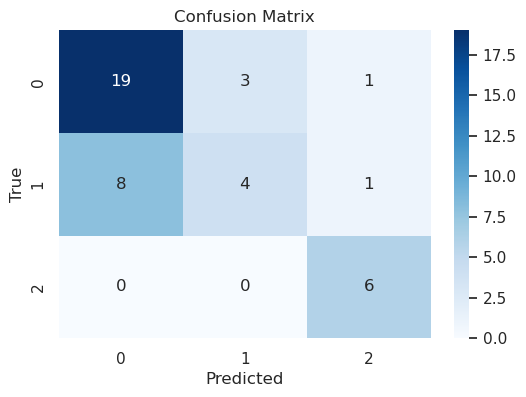

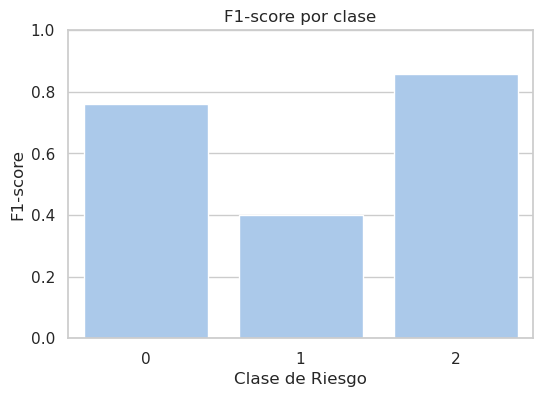

In [427]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_per_class = {k: v["f1-score"] for k, v in report_dict.items() if k.isdigit()}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(f1_per_class.keys()), y=list(f1_per_class.values()))
plt.ylabel("F1-score")
plt.xlabel("Clase de Riesgo")
plt.title("F1-score por clase")
plt.ylim(0, 1)
plt.show()